# Sentiment classification on E-commerce dataset
----
----

## Workflow
-----

### 1. About Data, Machine Learning Formulation and EDA

### 2. Preprocessing

### 3. Feature Engineering

### 4. Modeling and hypertuining

### 5. Result and deploying prediction pipeline


### Explanation . . .. 

![](http://)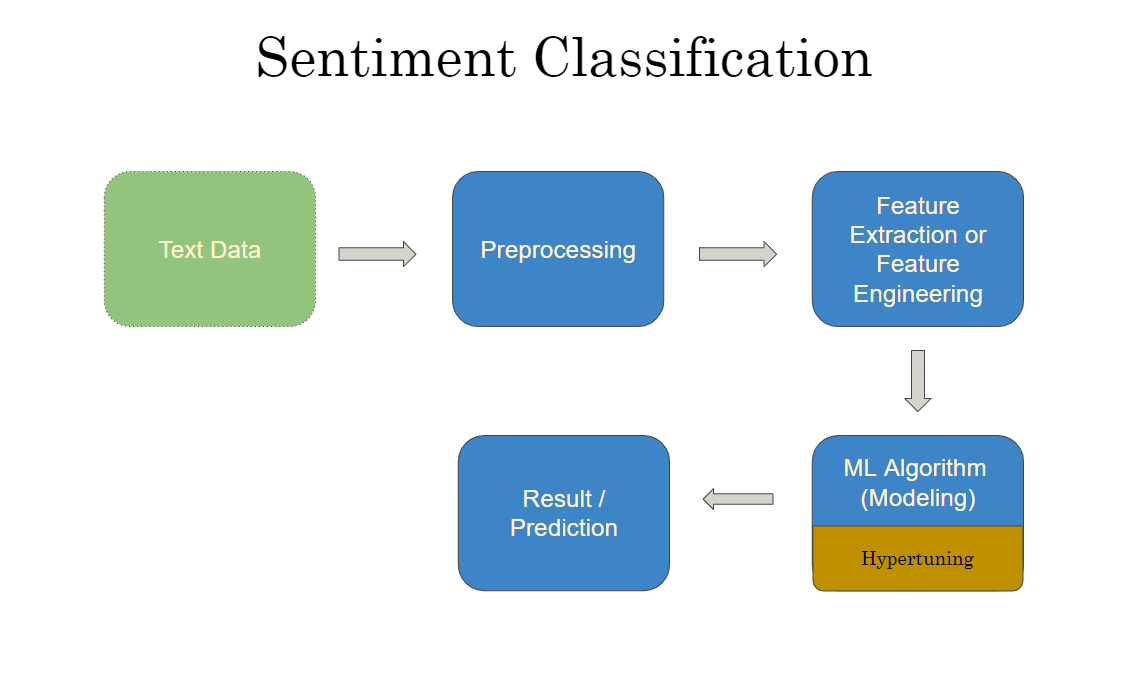

----

###  Importing llibraries

In [ ]:
# Any results you write to the current directory are saved as output.
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Ignore all warnings
import warnings
warnings.filterwarnings("ignore")
        
# Importing Libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.model_selection import train_test_split # for spliting dataset
from sklearn.feature_extraction.text import CountVectorizer # bow-->1gram and 2 gram
from sklearn.feature_extraction.text import TfidfVectorizer # tf-idf
from gensim.models import Word2Vec  # w2v
from gensim.models import KeyedVectors # to understanding w2v using google pre trained model
from sklearn.metrics import accuracy_score # to check the accuracy of model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score # k-fold cv
from sklearn.metrics import classification_report
import pickle
from wordcloud import WordCloud
from collections import Counter
from tqdm import tqdm
import re
import nltk
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
eng_stopwords = stopwords.words('english')
from nltk.stem import PorterStemmer
from sklearn.metrics import confusion_matrix,log_loss
from sklearn.metrics import balanced_accuracy_score
from sklearn.preprocessing import StandardScaler

# 1. About Data, Machine Learning Formulation and EDA

## 1.1 About Dataset


#### Dataset Source: https://www.kaggle.com/nicapotato/womens-ecommerce-clothing-reviews


### Context:
Welcome. This is a Women’s Clothing E-Commerce dataset revolving around the reviews written by customers. Its nine supportive features offer a great environment to parse out the text through its multiple dimensions. Because this is real commercial data, it has been anonymized, and references to the company in the review text and body have been replaced with “retailer”.


### Content:

#### This dataset includes 23486 rows and 10 feature variables. Each row corresponds to a customer review, and includes the variables:

**Clothing ID:** Integer Categorical variable that refers to the specific piece being reviewed.

**Age:** Positive Integer variable of the reviewers age.

**Title:** String variable for the title of the review.

**Review Text:** String variable for the review body.

**Rating:** Positive Ordinal Integer variable for the product score granted by the customer from 1 Worst, to 5 Best.

**Recommended IND:** Binary variable stating where the customer recommends the product where 1 is recommended, 0 is not recommended.

**Positive Feedback Count:** Positive Integer documenting the number of other customers who found this review positive.

**Division Name:** Categorical name of the product high level division.

**Department Name:** Categorical name of the product department name.

**Class Name:** Categorical name of the product class name.


### Note: Iam only using *'Review Text'* as features and *'Rating'* as class labels and converting into binary classification problem.
#### {1: positive sentiment, 0: Negative sentiment}

## 1.1.1. Loading the dataset and dataset Overview


In [ ]:
# Loading CSV file
data = pd.read_csv("../input/womens-ecommerce-clothing-reviews/Womens Clothing E-Commerce Reviews.csv",index_col=0)

# Using only 'Review text' and 'Rating' and descarding other columns
data = data[['Review Text','Rating']] 

# Converting into binary classification problem
data = data[data['Rating']!=3]
data['Rating'] = data['Rating'].apply(lambda x: 0 if x<3 else 1)

# Shape of dataset
print("Shape of the dataset:",data.shape)

# Overview of data
print("\nOverview of data: ")
data.info

## 1.2. Machine Learning Formulation

#### Its a simple Binary Classification 
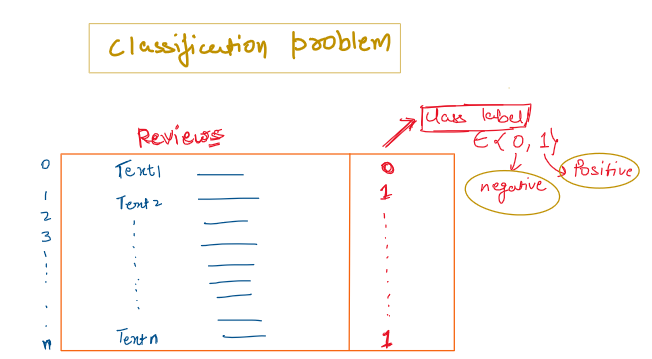

### 1.2.1. Evaluation Metric

#### 1. Logloss ass primary metric. (want to penalise based on probability score of each class and also for better interpretability of model for both of the class)
#### 2. Classification Report as secondary metric (include accuracy, precision, recall, f1_score)  

## 1.3. EDA

* Dataset Overview
* Distribution of classlabel
* Missing Values and Duplicate values
* Number of words in review text distribution
* WordCloud (Visualisation of words frequency)
* Frequency distribution (Using countvectoriser ngram) 

### 1.3.1. Pandas Profiling

Learning Resource for pandas profiling:

1. https://towardsdatascience.com/a-better-eda-with-pandas-profiling-e842a00e1136

2. https://github.com/pandas-profiling/pandas-profiling


In [ ]:
# Pandas Profiling : Really good library to get the overview EDA.
profile = ProfileReport(data, title='Pandas Profiling Report',minimal=False, html={'style':{'full_width':True}})
profile.to_widgets()

### 1.3.2 Missing Values and Duplicate values

In [ ]:
# Finding missing values
print(f"Number of Missing values: \n{data.isnull().sum()}\n")

print(f"number of duplicated reviews: {sum(data[data['Review Text'].notnull()].duplicated(['Review Text'],keep='first'))}")

In [ ]:
# Duplicate Review text example
data[data['Review Text'].notnull()][data[data['Review Text'].notnull()].duplicated(['Review Text'],keep=False)]

### 1.3.2 Distribution of class labels(sentiments)

In [ ]:
# Removing datapoints having missing values and duplicate Review text
data_after_drop = data[data['Review Text'].notnull()]
data_after_drop = data_after_drop.drop_duplicates(['Review Text'],keep='first')

print(f"percentage of data remaing after dopping missing values and duplicate reviews: { round((data_after_drop.shape[0]/data.shape[0])*100,3)} %")

In [ ]:
# Classlabel value counts

temp  = data_after_drop['Rating'].value_counts()
print(pd.DataFrame({'Class label(sentiment)':temp.index, "values_counts":temp.values,"distribution percentage":temp.values/sum(temp.values) }))

# Ploting distribution of classlabel
sn.countplot(data_after_drop['Rating'])
plt.show()

Observation:
* Class labels are high imbalance. Using accuracy as metric is really not a good idea to check the performance of model.

### 1.3.3. Distribution of Number of words in Reviews text

In [ ]:
num_of_words = data_after_drop['Review Text'].apply(lambda x: len(str(x).split()))

# Ploting
sn.distplot(num_of_words[data_after_drop['Rating']==1],label = 'Positive Sentiments')
sn.distplot(num_of_words[data_after_drop['Rating']==0],label = 'Negative Sentiments')
plt.legend()
plt.title("Distribution of Number of words in Reviews text ")
plt.show()

In [ ]:
"""sn.boxplot(num_of_words,hue=data_after_drop['Rating'])
plt.show()"""

### 1.3.4. Word Cloud

In [ ]:
# refer: https://www.datacamp.com/community/tutorials/wordcloud-python

text_train = " ".join(word for word in data_after_drop['Review Text'])

# Create and generate a word cloud image:
wordcloud = WordCloud().generate(text_train)

# Display the generated image:
plt.figure(figsize=(11,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("WordCloud of Review Text\n")
plt.axis("off")
plt.show()

### 1.3.5. WordCloud hue by class label

In [ ]:
# WordCloud hue by class label

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 6))

# For Positive Sentiment 
text = " ".join(word for word in data_after_drop[data_after_drop['Rating']==1]['Review Text'])
# Create and generate a word cloud image:
wordcloud = WordCloud().generate(text)

# Display the generated image:
ax1.imshow(wordcloud, interpolation='bilinear')
ax1.set(title='WordCloud of Positive Text\n')
ax1.axis("off")

# -------------------------------------------------------------------------------------------------

# For Negative Sentiment 
text = " ".join(word for word in data_after_drop[data_after_drop['Rating']==0]['Review Text'])
# Create and generate a word cloud image:
wordcloud = WordCloud().generate(text)

# Display the generated image:
ax2.imshow(wordcloud, interpolation='bilinear')
ax2.set(title='WordCloud of Negative Review Text\n')
ax2.axis("off")
plt.show()

## 2. Preprocessing

1. tokenize and lowering words
2. Decontraction (mis spelled words)
3. Cleaning(html tags remove, punctuation remove etc)
4. stopwords remove
5. lemmatization or stemming
5. Unnecessary words remove(word_len<3)


In [ ]:
# Preprocessing Functions
# credit : https://www.kaggle.com/urvishp80/quest-encoding-ensemble

#======================================================================================================================================
# Return the number of links and text without html tags 
# Also return the counts of 'number of lines'  and remove it
def strip_html(text):
    """ Return theclean text (without html tags) """
    
    # Removing HTML tags
    text = re.sub(r'http[s]?://\S+'," ",text)
    
    # finding number of lines using regex and counting it and remove it
    text = re.sub(r'\n', " ",text)
    
    return  text


#======================================================================================================================================
mispell_dict = {"aren't" : "are not","can't" : "cannot","couldn't" : "could not","couldnt" : "could not","didn't" : "did not","doesn't" : "does not",
                "doesnt" : "does not","don't" : "do not","hadn't" : "had not","hasn't" : "has not","haven't" : "have not","havent" : "have not",
                "he'd" : "he would","he'll" : "he will","he's" : "he is","i'd" : "i would","i'd" : "i had","i'll" : "i will","i'm" : "i am",
                "isn't" : "is not","it's" : "it is","it'll":"it will","i've" : "I have","let's" : "let us","mightn't" : "might not",
                "mustn't" : "must not","shan't" : "shall not","she'd" : "she would","she'll" : "she will","she's" : "she is","shouldn't" : "should not",
                "shouldnt" : "should not","that's" : "that is","thats" : "that is","there's" : "there is","theres" : "there is","they'd" : "they would",
                "they'll" : "they will","they're" : "they are","theyre":  "they are","they've" : "they have","we'd" : "we would","we're" : "we are",
                "weren't" : "were not","we've" : "we have","what'll" : "what will","what're" : "what are","what's" : "what is","what've" : "what have",
                "where's" : "where is","who'd" : "who would","who'll" : "who will","who're" : "who are","who's" : "who is","who've" : "who have",
                "won't" : "will not","wouldn't" : "would not","you'd" : "you would","you'll" : "you will","you're" : "you are","you've" : "you have",
                "'re": " are","wasn't": "was not","we'll":" will","didn't": "did not","tryin'":"trying"}

def _get_mispell(mispell_dict):
    mispell_re = re.compile('(%s)' % '|'.join(mispell_dict.keys()))
    return mispell_dict, mispell_re

def replace_typical_misspell(text):
    
    text = text.lower()
    
    
    """De-Concatenation of words and correction of misspelled words"""
    mispellings, mispellings_re = _get_mispell(mispell_dict)

    def replace(match):
        return mispellings[match.group(0)]

    return mispellings_re.sub(replace, text)


#======================================================================================================================================
# removing non_alpha_numeric character and removing all the special character words
def non_alpha_numeric_remove(text):  
    
    # removing all non alpha char 
    text = re.sub(r"[^A-Za-z]", " ",text)
    
    return text 

#======================================================================================================================================

# function to remove all the stopwords and words having lengths less than 3
def remove_stop_words_and_punc(text) :
    
    """ 
    Remove all the stopwords 
    
    """
    # removing the words from the stop words list: 'no', 'nor', 'not'
    stops = set(stopwords.words("english"))
    stops.remove('no')
    stops.remove('nor')
    stops.remove('not')
    
    clean_text = []
    for word in text.split():
        if word not in stops and len(word)>3:        
            clean_text.append(word)
        
    clean_text = " ".join(clean_text)
    
    return(clean_text)

#======================================================================================================================================
# function for stemming of words in text
def stem(text):
    stemmer = PorterStemmer()
    result = " ".join([ stemmer.stem(word) for word in text.split(" ")])
    return result

#======================================================================================================================================
#======================================================================================================================================
# Final text cleaning funtion  
def clean_text(text):
    """
    This function sequentially execute all the cleaning and preprocessing function and finaly gives cleaned text.
    Input: Boolean values of extra_features, strip_html, count_all_cap_words_and_lower_it, replace_typical_misspell, count_non_alpha_numeric_and_remove, remove_stop_words_and_punc, stem
            (by default all the input values = True)
    
    return: clean text
    
    """
    
    # remove html tags
    clean_text = strip_html(text)  
    
    # de-concatenation of words
    clean_text = replace_typical_misspell(clean_text)
     
    # Count the number of non alpha numeric character and remove it
    clean_text = non_alpha_numeric_remove(clean_text)
    
    # removing Stopwords and the words length less than 3(As these words mostly tend to redundant words) excpect 'C' and 'R'and 'OS' <-- programing keywords
    clean_text = remove_stop_words_and_punc(clean_text)
    
    # stemming ( use only for BOW or TFIDF represention. Not effective for word embedding like w2v or glove)
    clean_text = stem(clean_text)

    return clean_text

In [ ]:
# Preprocessing 
cleaned_review_text = data_after_drop['Review Text'].apply(lambda x: clean_text(x))

# Sample
i=15
print(f"\nBefore Preprocessing\n{'='*20}")
print(data_after_drop['Review Text'].iloc[i])

print(f"\nAfter Preprocessing\n{'='*20}")
print(cleaned_review_text.iloc[i])

### 2.1. Distribution  number of word in text (before and after preprocessing)

In [ ]:
# Calculating the length of text before and after preprocessing
len_after_cleaning = cleaned_review_text.apply(lambda x : len(x.split()))
len_before_cleaning = data_after_drop['Review Text'].apply(lambda x : len(x.split()))
    
# ploting
plt.figure(figsize=(9,6))
sn.distplot(len_before_cleaning, label=f'Review text before cleaning')
sn.distplot(len_after_cleaning, label=f'Review text after cleaning')
plt.title(f" Distribution of number of words of Review text before v/s after preprocessing\n",fontsize=15)
plt.ylabel("distribtion")
plt.xlabel(f"number of words in Review text")
plt.legend()
plt.grid()
plt.show()

In [ ]:
"""# Calculating the length of text before and after preprocessing
len_after_cleaning = cleaned_review_text[data_after_drop['Rating']==1].apply(lambda x : len(x.split()))
len_before_cleaning = cleaned_review_text[data_after_drop['Rating']==0].apply(lambda x : len(x.split()))

# ploting
plt.figure(figsize=(9,6))
sn.distplot(len_before_cleaning, label=f'Review text before cleaning')
sn.distplot(len_after_cleaning, label=f'Review text after cleaning')
plt.title(f" Distribution of number of words of Review text before v/s after preprocessing\n",fontsize=15)
plt.ylabel("distribtion")
plt.xlabel(f"number of words in Review text")
plt.legend()
plt.grid()
plt.show()"""

print("number of words after preprocessing hue by class label")

### 2.1. WordCloud after preprocessing (hue by class label)

In [ ]:
# WordCloud hue by class label

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 6))

# For Positive Sentiment 
text = " ".join(word for word in cleaned_review_text[data_after_drop['Rating']==1])
# Create and generate a word cloud image:
wordcloud = WordCloud().generate(text)

# Display the generated image:
ax1.imshow(wordcloud, interpolation='bilinear')
ax1.set(title='WordCloud of Positive Text\n')
ax1.axis("off")

# -------------------------------------------------------------------------------------------------

# For Negative Sentiment 
text = " ".join(word for word in cleaned_review_text[data_after_drop['Rating']==0])
# Create and generate a word cloud image:
wordcloud = WordCloud().generate(text)

# Display the generated image:
ax2.imshow(wordcloud, interpolation='bilinear')
ax2.set(title='WordCloud of Negative Review Text\n')
ax2.axis("off")
plt.show()

### 2.2 Top Frequency of words in positive class

In [ ]:
top = Counter([item for sublist in cleaned_review_text[data_after_drop['Rating']==1] for item in str(sublist).split()])
temp = pd.DataFrame(top.most_common(20))
temp = temp.iloc[1:,:]
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Purples')

### 2.2 Top Frequency of words in negative class

In [ ]:
top = Counter([item for sublist in cleaned_review_text[data_after_drop['Rating']==0] for item in str(sublist).split()])
temp = pd.DataFrame(top.most_common(20))
temp = temp.iloc[1:,:]
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Purples')

## 3. Feature Engineering or Feature Extraction

#### 3.1. Bag of Words (countvectoriser)
#### 3.2. TF-IDF
#### 3.3. Word2Vec pretrained
#### 3.4. Word2Vec trained on own corpus

### Train Test Split

In [ ]:
# train test split

X = data_after_drop['Review Text']
y = data_after_drop['Rating']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=42)

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_val: {X_val.shape}")
print(f"Shape of y_val: {y_val.shape}")

#### Preprocessing for BOW and TFIDF

In [ ]:
# Preprocessing for BOW and TFIDF
X_train_clean_text = X_train.apply(lambda x: clean_text(x))
X_val_clean_text = X_val.apply(lambda x: clean_text(x))

### 3.1. Bag of Words (BOW)
Refer: https://www.slideshare.net/hadyelsahar/word-embedings-why-the-hype-55769273

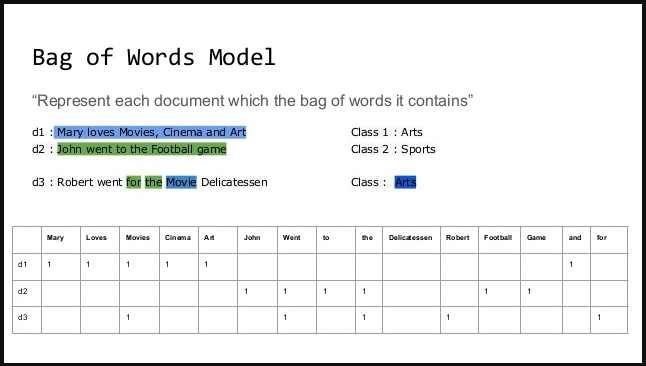

### N-gram Explaination
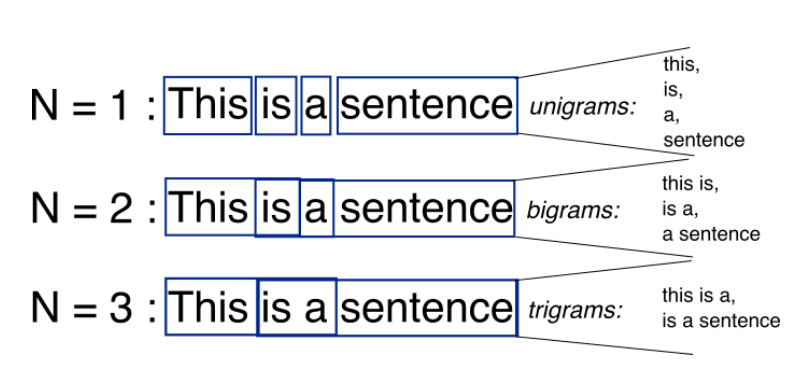

#### 3.1.1. BOW - unigram 

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer(ngram_range=(1, 1), max_df=1.0, min_df=1, max_features=None, vocabulary=None)
x_train_bow_unigram = count_vect.fit_transform(X_train_clean_text)
x_val_bow_unigram = count_vect.transform(X_val_clean_text)

print(f"shape of features after BOW Feture extraction: {x_train_bow_unigram.shape}")

# Sparsity of BOW-unigram
sparsiry_bow = (len(x_train_bow_unigram.toarray().nonzero()[0]) / len(np.nonzero(x_train_bow_unigram.toarray()==0)[0]))*100
print(f"Sparsity of BOW: {round(sparsiry_bow,5)}%")

In [ ]:
# BOW feature representaiona
bow_unigram_feature_representation = pd.DataFrame(data = x_train_bow_unigram.toarray(), columns = count_vect.get_feature_names())
bow_unigram_feature_representation.head()

#### 3.1.2. BOW - bigram

### 3.2. TF-IDF

https://www.slideshare.net/hadyelsahar/word-embedings-why-the-hype-55769273

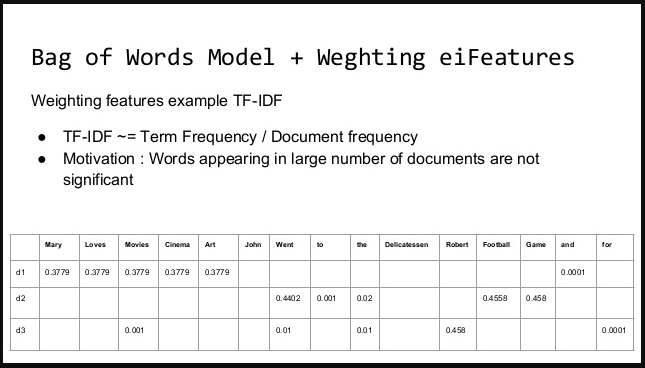


Refer: https://towardsdatascience.com/3-basic-approaches-in-bag-of-words-which-are-better-than-word-embeddings-c2cbc7398016

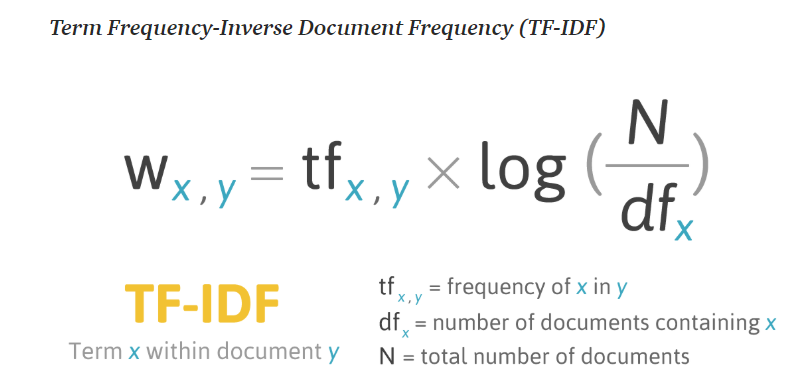

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vect = TfidfVectorizer(ngram_range=(1, 1), max_df=1.0, min_df=1, max_features=None, vocabulary=None)
x_train_tfidf_unigram = tfidf_vect.fit_transform(X_train_clean_text)
x_val_tfidf_unigram = tfidf_vect.transform(X_val_clean_text)

print(f"shape of features after BOW Feture extraction: {x_train_tfidf_unigram.shape}")

# Sparsity of TFIDF-unigram
sparsiry_tfidf = (len(x_train_tfidf_unigram.toarray().nonzero()[0]) / len(np.nonzero(x_train_tfidf_unigram.toarray()==0)[0]))*100
print(f"Sparsity of TFIDF: {round(sparsiry_tfidf,5)}%")

In [ ]:
# Tf-IDF feature representaion
tfidf_unigram_feature_representation = pd.DataFrame(data = x_train_tfidf_unigram.toarray(), columns = tfidf_vect.get_feature_names())
tfidf_unigram_feature_representation.head()

### 3.2 Word2vec 

#### problem with BOW or TFIDF approach

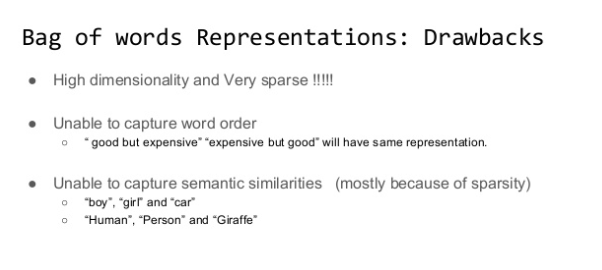


#### Intuition of W2V 

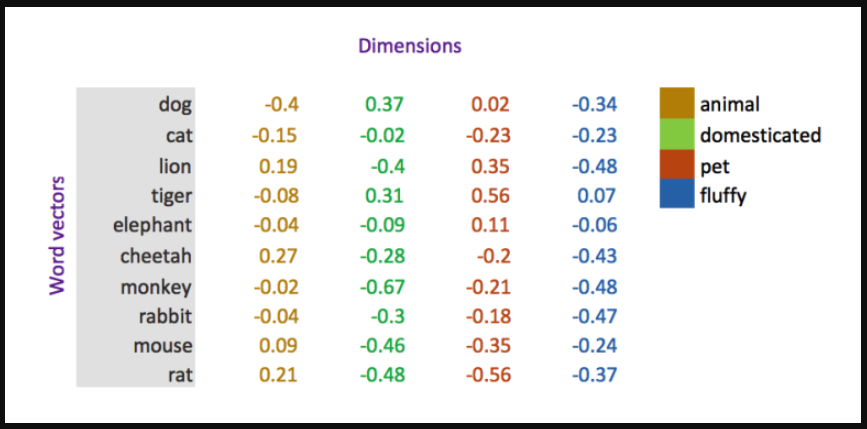

Word2vec Visualiser: http://projector.tensorflow.org/

#### W2V try to capture the semantic of word with respect to its neighborhood s.t. distance between simantically similar words is less than distance between non similar.simantical words.
Example
1. (kids,child) --> simantically similar
2. (kids, baseball) --> simantically unsimilar

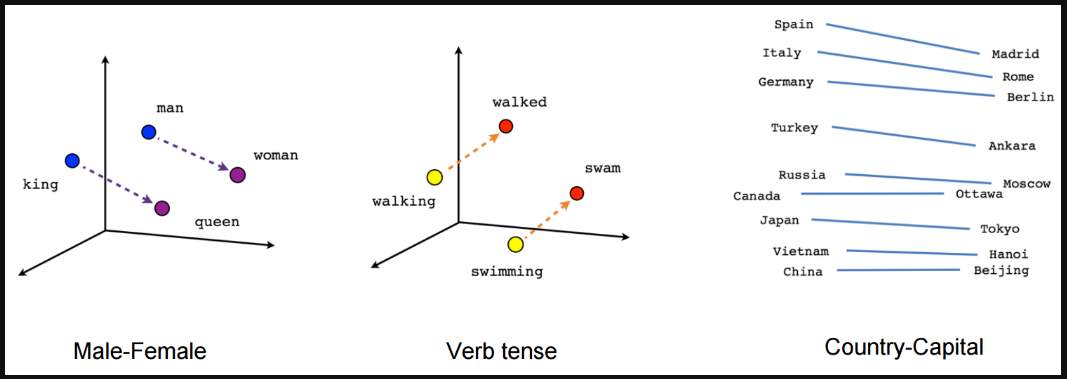

### 3.2. Word2vec trained on our own corpus

#### Preprocessing for Embeddings

In [ ]:
# Text Preprocessing funtion for word2vec
def clean_text_for_embedding(text):
    """
    This function sequentially execute all the cleaning and preprocessing function and finaly gives cleaned text.
    Input: Boolean values of extra_features, strip_html, count_all_cap_words_and_lower_it, replace_typical_misspell, count_non_alpha_numeric_and_remove, remove_stop_words_and_punc, stem
            (by default all the input values = True)
    
    return: clean text """
    
    # remove html tags
    clean_text = strip_html(text)  
    
    # de-concatenation of words
    clean_text = replace_typical_misspell(clean_text)
     
    # Count the number of non alpha numeric character and remove it
    clean_text = non_alpha_numeric_remove(clean_text)
    
    # removing Stopwords and the words length less than 3(As these words mostly tend to redundant words) excpect 'C' and 'R'and 'OS' <-- programing keywords
    clean_text = remove_stop_words_and_punc(clean_text)

    return clean_text

In [ ]:
# Preprocessing for word2vec embedding for train and test review text
X_train_review_text_for_embedding = X_train.apply(lambda x: clean_text_for_embedding(x))
X_val_review_text_for_embedding = X_val.apply(lambda x: clean_text_for_embedding(x))


# Sample
i=15
print(f"\nBefore Preprocessing\n{'='*20}")
print(X_train.iloc[i])

print(f"\nAfter Preprocessing\n{'='*20}")
print(X_train_review_text_for_embedding.iloc[i])

#### W2V Embeddings using CBOW

In [ ]:
import operator 
import gensim
from gensim.models import KeyedVectors

# Train the genisim word2vec model with our own custom corpus
# CBOW -> sg = 0

# Convering text in list of list of train reviews text
list_of_sent_train = X_train_review_text_for_embedding.apply(lambda x: x.split()).values

# Convering text in list of list of val reviews text
list_of_sent_val = X_val_review_text_for_embedding.apply(lambda x: x.split()).values

# Traing W2V
model_cbow = Word2Vec(sentences= list_of_sent_train, min_count=3, sg=0, workers= 3,size=100) # Default setting

In [ ]:
# Vocab after training
words = model_cbow.wv.vocab.keys()
print("Number of words in vocab",len(words),"\n\n")
print(words,sep='\n')

In [ ]:
# Top similar word
model_cbow.similar_by_word("good")

#### AVG W2V Feature Exraction

In [ ]:
'''
    -->procedure to make avg w2v of each reviews
    
    1. find the w2v of each word
    2. sum-up w2v of each word in a sentence
    3. divide the total w2v of sentence by total no. of words in the sentence
'''

# vocablary of w2v model of e-commerce dataset
vocab=model_cbow.wv.vocab


#------------------------------------------------------------------------------------------------------------
## average Word2Vec for train reviews
# compute average word2vec for each review.
train_w2v_cbow = [] # the avg-w2v for each sentence/review in train dataset is stored in this list

list_of_sent_train = X_train_review_text_for_embedding.apply(lambda x: x.split()).values

for sent in list_of_sent_train: # for each review/sentence
    sent_vec = np.zeros(100) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in vocab:
            vec = model_cbow.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    train_w2v_cbow.append(sent_vec)

print("Number of datapoints in train: ",len(train_w2v_cbow))


#------------------------------------------------------------------------------------------------------------

## average Word2Vec for val reviews
# compute average word2vec for each review.
val_w2v_cbow = [] # the avg-w2v for each sentence/review in train dataset is stored in this list

list_of_sent_train = X_val_review_text_for_embedding.apply(lambda x: x.split()).values

for sent in list_of_sent_val: # for each review/sentence
    sent_vec = np.zeros(100) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in vocab:
            vec = model_cbow.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    val_w2v_cbow.append(sent_vec)

print("Number of datapoints in val: ",len(val_w2v_cbow))

#### Standard scaling of Avg W2V (Trained on own corpus)

In [ ]:
# Standard scaling of W2V
sc = StandardScaler()
train_w2v_sc = sc.fit_transform(train_w2v_cbow)
val_w2v_sc = sc.transform(val_w2v_cbow)


## Example : Review text is encoded into 100 dim vector space
print(f"\n Before encoding: \n{'='*20}\n {X_train_review_text_for_embedding.iloc[0]}")
print(f"\n After encoding: \n{'='*20}\n {train_w2v_sc[0]}")

#### Visualizing Reviews text using Avg W2V CBOW

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns

# PCA for visualisation
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(train_w2v_sc)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

# Ploting
sns.scatterplot(x='principal component 1', y='principal component 2', hue=y_train.values, style=None, size=None, data=principalDf)
plt.show()

### 3.2. Word2vec - pretrained (Glove)

In [ ]:
# Loading Glove(pretrained) model
GLOVE_EMBEDDING_PATH = '../input/glove840b300dtxt/glove.840B.300d.txt'

def get_coefs(word, *arr):
    return word, np.asarray(arr, dtype='float32')

def load_embeddings(path):
    with open(path) as f:
        return dict(get_coefs(*line.strip().split(' ')) for line in tqdm(f))
    
embeddings_index = load_embeddings(GLOVE_EMBEDDING_PATH)

#### Building vocubulary from our Dataset
Refer: https://www.kaggle.com/phoenix9032/quest-preprocessing-data-for-embedding

In [ ]:
## Building vocubulary from our Quest Data
def build_vocab(sentences, verbose =  True):
    """
    :param sentences: list of list of words
    :return: dictionary of words and their count
    """
    vocab = {}
    for sentence in tqdm(sentences, disable = (not verbose)):
        for word in sentence:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1
    return vocab

#=========================================================================================================
import operator 
## This is a common function to check coverage between our quest data and the word embedding
def check_coverage(vocab,embeddings_index):
    a = {}
    oov = {}
    k = 0
    i = 0
    for word in tqdm(vocab):
        try:
            a[word] = embeddings_index[word]
            k += vocab[word]
        except:

            oov[word] = vocab[word]
            i += vocab[word]
            pass

    print('Found embeddings for {:.2%} of vocab'.format(len(a) / len(vocab)))
    print('Found embeddings for  {:.2%} of all text'.format(k / (k + i)))
    sorted_x = sorted(oov.items(), key=operator.itemgetter(1))[::-1]

    return sorted_x

#### Check Coverage for review_text_for_embedding

In [ ]:
##Apply the vocab function to get the words and the corresponding counts
sentences = X_train_review_text_for_embedding.apply(lambda x: x.split()).values
vocab = build_vocab(sentences)

print(f"\nFor cleaned_question_body_for_embedding: \n{'-'*40}")
oov = check_coverage(vocab,embeddings_index)

## List 10 out of vocabulary word
print(f"\nTop 10 out of vocabulary word: \n{'-'*30}")
oov[:10]

#### AVG W2V using pretrained model

In [ ]:
#------------------------------------------------------------------------------------------------------------
## average Word2Vec usnig pretrained model(GLOVE) for train reviews
# compute average word2vec for each review.
train_w2v_pretrained = [] # the avg-w2v for each sentence/review in train dataset is stored in this list

list_of_sent_train = X_train_review_text_for_embedding.apply(lambda x: x.split()).values

for sent in list_of_sent_train: # for each review/sentence
    sent_vec = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in vocab:
            try:
                vec = embeddings_index[word]
                sent_vec += vec
                cnt_words += 1
            
            except:
                pass
            
    if cnt_words != 0:
        sent_vec /= cnt_words
    train_w2v_pretrained.append(sent_vec)

print("Number of datapoints in train: ",len(train_w2v_pretrained))


#------------------------------------------------------------------------------------------------------------

## average Word2Vec for val reviews
# compute average word2vec for each review.
val_w2v_pretrained = [] # the avg-w2v for each sentence/review in train dataset is stored in this list

list_of_sent_train = X_val_review_text_for_embedding.apply(lambda x: x.split()).values

for sent in list_of_sent_val: # for each review/sentence
    sent_vec = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in vocab:
            try:     
                vec = embeddings_index[word]
                sent_vec += vec
                cnt_words += 1
                
            except:
                pass
    if cnt_words != 0:
        sent_vec /= cnt_words
    val_w2v_pretrained.append(sent_vec)

print("Number of datapoints in val: ",len(val_w2v_pretrained))

In [ ]:
# Standard scaling of W2V
sc = StandardScaler()
train_w2v_pretrained_sc = sc.fit_transform(train_w2v_pretrained)
val_w2v_pretrained_sc = sc.transform(val_w2v_pretrained)


## Example : Review text is encoded into 100 dim vector space
print(f"\n Before encoding: \n{'='*20}\n {X_train_review_text_for_embedding.iloc[0]}")
print(f"\n After encoding: \n{'='*20}\n {train_w2v_pretrained_sc[0]}")

#### Visualising AVG W2V pretrained model using PCA

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns

# PCA for visualisation
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(train_w2v_pretrained_sc)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

# Ploting
sns.scatterplot(x='principal component 1', y='principal component 2', hue=y_train.values, style=None, size=None, data=principalDf)
plt.show()

# 4. Modeling

### 4.1. Logistic Regression on BOW

In [ ]:
# Applying Logistic Regression with L2 regularization on BOW

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

"""
y_true : array, shape = [n_samples] or [n_samples, n_classes]
True binary labels or binary label indicators.

y_score : array, shape = [n_samples] or [n_samples, n_classes]
Target scores, can either be probability estimates of the positive class, confidence values, or non-thresholded measure of
decisions (as returned by “decision_function” on some classifiers). 
For binary y_true, y_score is supposed to be the score of the class with greater label.

"""

train_loss = []
cv_loss = []
c_range=[10e-5,10e-4,10e-3,10e-2,1,10,10e1,10e2,10e3]
for i in c_range:
    
    clf=LogisticRegression(penalty='l2', C=i,class_weight='balanced')
    clf.fit(x_train_bow_unigram, y_train)
    
    # Predicting
    y_train_pred = clf.predict_proba(x_train_bow_unigram)
    y_cv_pred = clf.predict_proba(x_val_bow_unigram)
    
    # Loss metric storing
    train_loss.append(log_loss(y_train, y_train_pred))
    cv_loss.append(log_loss(y_val, y_cv_pred))
    
    
# Visualising and finding optimal parameter 
plt.plot(np.arange(1,10,1), train_loss, label='Train loss')
plt.plot(np.arange(1,10,1), cv_loss, label='CV loss')
plt.xticks( np.arange(1,10,1), (10e-5, 10e-4, 10e-3, 10e-2, 10e-1, 10e0, 10e1, 10e2, 10e3))
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("log loss")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()



## Training using Optimal hyperparemeter
# using optimum_k to find generalistion loss

optimum_c = c_range[np.argmin(cv_loss)] #optimum 'alpha'

# Naive Bayes training
print(f"Traing using optimal alpha:  {c_range[np.argmin(cv_loss)]}\n")
clf=LogisticRegression(penalty='l2', C=optimum_c,class_weight='balanced')
clf.fit(x_train_bow_unigram, y_train)
    
y_pred = clf.predict(x_val_bow_unigram)
y_pred_proba = clf.predict_proba(x_val_bow_unigram)

# Result track
accuracy = accuracy_score(y_val,y_pred)
bal_accuracy = balanced_accuracy_score(y_val,y_pred)
logloss = log_loss(y_val,y_pred_proba)
print(f'\nGenearalisation log_loss: {logloss:.3f}')
print(f"\nGeneralisation Accuracy: {(round(accuracy,2))*100}%")
print(f"\nGeneralisation Balance accuracy: {(round(bal_accuracy,2))*100}%")
print(f'\nmisclassification percentage: {(1-accuracy)*100:.2f}%')


#ploting confusion matrix
sn.heatmap(confusion_matrix(y_pred,y_val),annot=True, fmt="d",linewidths=.5)
plt.title('Confusion Matrix')
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.show()
# Classification Report
print("\n\nclassification report:\n",classification_report(y_val,y_pred)) 

### LIME (Logistic Regression on BOW)

1. Preprocessed all the text
2. Split the data into train and text
3. Create Pipeline of feature_extraction(count_vect) and model(Logistic reg.)
4. Create LimeTextExplainer object
5. Explain the prediction of text_instance given by classifier_fn 

In [ ]:
from lime import lime_text
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer
from lime.lime_text import LimeTextExplainer

# Countvectoriser
count_vect = CountVectorizer(ngram_range=(1, 1), max_df=1.0, min_df=1, max_features=None, vocabulary=None)
x_train_bow_unigram = count_vect.fit_transform(X_train_clean_text)
x_val_bow_unigram = count_vect.transform(X_val_clean_text)

# Model Training
clf=LogisticRegression(penalty='l2', C=1.0)
clf.fit(x_train_bow_unigram,y_train)

# Creating Pipeline
pipe = make_pipeline(count_vect, clf)

# LimeTextExplainer 
class_names = ['Negative sentiment','Positive Sentiment']
explainer = LimeTextExplainer(class_names=class_names, kernel_width=25, verbose=True, feature_selection='auto', bow=True)

#### Correct Prediction

#### Example 1

In [ ]:
# Prediction
idx = 115
exp = explainer.explain_instance(text_instance = X_val_clean_text.iloc[idx], classifier_fn = pipe.predict_proba, num_features=10,num_samples=5000,distance_metric='cosine')
print('\nDocument id: %d' % idx)
print(f"Before Preprocessing\n{'-'*20}\n{X_val.iloc[idx]}\n")
print(f"After Preprocessing\n{'-'*20}\n{X_val_clean_text.iloc[idx]}\n")

print('Probability(Negative sentiment) =',pipe.predict_proba([X_val_clean_text.iloc[idx]])[0,0])
print('Probability(Positive sentiment) =',pipe.predict_proba([X_val_clean_text.iloc[idx]])[0,1])
print('True class: %s' % class_names[y_train[idx]])

# Local Explanability
%matplotlib inline
fig = exp.as_pyplot_figure()

In [ ]:
exp.show_in_notebook(text=True)

#### Example 2

In [ ]:
# Prediction
idx = 115
exp = explainer.explain_instance(text_instance = X_val_clean_text.iloc[idx], classifier_fn = pipe.predict_proba, num_features=10,num_samples=5000,distance_metric='cosine')
print('\nDocument id: %d' % idx)
print(f"Before Preprocessing\n{'-'*20}\n{X_val.iloc[idx]}\n")
print(f"After Preprocessing\n{'-'*20}\n{X_val_clean_text.iloc[idx]}\n")

print('Probability(Negative sentiment) =', pipe.predict_proba([X_val_clean_text.iloc[idx]])[0,0])
print('Probability(Positive sentiment) =', pipe.predict_proba([X_val_clean_text.iloc[idx]])[0,1])
print('True class: %s' % class_names[y_train[idx]])

# Local Explanability
%matplotlib inline
fig = exp.as_pyplot_figure()

In [ ]:
exp.show_in_notebook(text=True)

----

#### Incorrect prediction

In [ ]:
# Prediction
idx = 25


exp = explainer.explain_instance(text_instance = X_val_clean_text.iloc[idx], classifier_fn = pipe.predict_proba, num_features=10,num_samples=5000,distance_metric='cosine')
print('\nDocument id: %d' % idx)
print(f"Before Preprocessing\n{'-'*20}\n{X_val.iloc[idx]}\n")
print(f"After Preprocessing\n{'-'*20}\n{X_val_clean_text.iloc[idx]}\n")

print('Probability(Negative sentiment) =', pipe.predict_proba([X_val_clean_text.iloc[idx]])[0,0])
print('Probability(Positive sentiment) =', pipe.predict_proba([X_val_clean_text.iloc[idx]])[0,1])
print('True class: %s' % class_names[y_train.iloc[idx]])

# Local Explanability
%matplotlib inline
fig = exp.as_pyplot_figure()



In [ ]:
exp.show_in_notebook(text=True)

****

### 4.2. Logistic Regression on BOW + SMOTE

In [ ]:
# Applying SMOTE to balance the dataset
# imbalanced-learn API: https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.over_sampling.SMOTE.html
from imblearn.over_sampling import SMOTE

# transform the dataset
oversample = SMOTE(sampling_strategy='auto',random_state=None,k_neighbors=5,n_jobs=None)
X_res_bow, y_res = oversample.fit_resample(x_train_bow_unigram, y_train)

# summarize the new class distribution
counter = Counter(y_res)
print("After applying SMOTE: ",counter)

In [ ]:
train_loss = []
cv_loss = []
alpha_range = [10e-5,10e-4,10e-3,10e-2,1,10,10e1,10e2,10e3]
for i in alpha_range:
    
    # Training
    clf = LogisticRegression(penalty='l2', C=i,class_weight='balanced')
    clf.fit(X_res_bow, y_res)
    
    # Predicting
    y_train_pred = clf.predict_proba(X_res_bow)
    y_cv_pred = clf.predict_proba(x_val_bow_unigram)
    
    # Loss metric storing
    train_loss.append(log_loss(y_res,y_train_pred))
    cv_loss.append(log_loss(y_val, y_cv_pred))

    
# Visualising and finding optimal parameter 
plt.plot(np.arange(1,10,1), train_loss, label='Train loss')
plt.plot(np.arange(1,10,1), cv_loss, label='CV loss')
plt.xticks( np.arange(1,10,1), (10e-5, 10e-4, 10e-3, 10e-2, 10e-1, 10e0, 10e1, 10e2, 10e3))
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("log loss")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()


## Training using Optimal hyperparemeter
# using optimum_k to find generalistion loss

optimum_c = c_range[np.argmin(cv_loss)] #optimum 'alpha'

# Naive Bayes training
print(f"Traing using optimal alpha:  {c_range[np.argmin(cv_loss)]}\n")
clf=LogisticRegression(penalty='l2', C=optimum_c,class_weight='balanced')
clf.fit(X_res_bow, y_res)

y_pred = clf.predict(x_val_bow_unigram)
y_pred_proba = clf.predict_proba(x_val_bow_unigram)

# Result track
accuracy = accuracy_score(y_val,y_pred)
bal_accuracy = balanced_accuracy_score(y_val,y_pred)
logloss = log_loss(y_val,y_pred_proba)
print(f'\nGenearalisation log_loss: {logloss:.3f}')
print(f"\nGeneralisation Accuracy: {(round(accuracy,2))*100}%")
print(f"\nGeneralisation Balance accuracy: {(round(bal_accuracy,2))*100}%")
print(f'\nmisclassification percentage: {(1-accuracy)*100:.2f}%')


#ploting confusion matrix
sn.heatmap(confusion_matrix(y_pred,y_val),annot=True, fmt="d",linewidths=.5)
plt.title('Confusion Matrix')
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.show()
# Classification Report
print("\n\nclassification report:\n",classification_report(y_val,y_pred)) 

### 4.3. Logistic Regression on TFIDF

In [ ]:
# Applying Logistic Regression with L2 regularization on BOW

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

"""
y_true : array, shape = [n_samples] or [n_samples, n_classes]
True binary labels or binary label indicators.

y_score : array, shape = [n_samples] or [n_samples, n_classes]
Target scores, can either be probability estimates of the positive class, confidence values, or non-thresholded measure of
decisions (as returned by “decision_function” on some classifiers). 
For binary y_true, y_score is supposed to be the score of the class with greater label.

"""

train_loss = []
cv_loss = []
c_range=[10e-5,10e-4,10e-3,10e-2,1,10,10e1,10e2,10e3]
for i in c_range:
    
    clf=LogisticRegression(penalty='l2', C=i,class_weight='balanced')
    clf.fit(x_train_tfidf_unigram, y_train)
    
    # Predicting
    y_train_pred = clf.predict_proba(x_train_tfidf_unigram)
    y_cv_pred = clf.predict_proba(x_val_tfidf_unigram)
    
    # Loss metric storing
    train_loss.append(log_loss(y_train, y_train_pred))
    cv_loss.append(log_loss(y_val, y_cv_pred))
    
    
# Visualising and finding optimal parameter 
plt.plot(np.arange(1,10,1), train_loss, label='Train loss')
plt.plot(np.arange(1,10,1), cv_loss, label='CV loss')
plt.xticks( np.arange(1,10,1), (10e-5, 10e-4, 10e-3, 10e-2, 10e-1, 10e0, 10e1, 10e2, 10e3))
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("log loss")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()



## Training using Optimal hyperparemeter
# using optimum_k to find generalistion loss

optimum_c = c_range[np.argmin(cv_loss)] #optimum 'alpha'

# Naive Bayes training
print(f"Traing using optimal alpha:  {c_range[np.argmin(cv_loss)]}\n")
clf=LogisticRegression(penalty='l2', C=optimum_c,class_weight='balanced')
clf.fit(x_train_tfidf_unigram, y_train)
    
y_pred = clf.predict(x_val_tfidf_unigram)
y_pred_proba = clf.predict_proba(x_val_tfidf_unigram)

# Result track
accuracy = accuracy_score(y_val,y_pred)
bal_accuracy = balanced_accuracy_score(y_val,y_pred)
logloss = log_loss(y_val,y_pred_proba)
print(f'\nGenearalisation log_loss: {logloss:.3f}')
print(f"\nGeneralisation Accuracy: {(round(accuracy,2))*100}%")
print(f"\nGeneralisation Balance accuracy: {(round(bal_accuracy,2))*100}%")
print(f'\nmisclassification percentage: {(1-accuracy)*100:.2f}%')


#ploting confusion matrix
sn.heatmap(confusion_matrix(y_pred,y_val),annot=True, fmt="d",linewidths=.5)
plt.title('Confusion Matrix')
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.show()
# Classification Report
print("\n\nclassification report:\n",classification_report(y_val,y_pred)) 

### LIME (Logistic regression on TFIDF)

1. Preprocessed all the text
2. Split the data into train and text
3. Create Pipeline of feature_extraction(TFIDF_vect) and model(Logistic reg.)
4. Create LimeTextExplainer object
5. Explain the prediction of text_instance given by classifier_fn 

In [ ]:
from lime import lime_text
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from lime.lime_text import LimeTextExplainer

# TFIDF vectoriser
tfidf_vect = TfidfVectorizer(ngram_range=(1, 1), max_df=1.0, min_df=1, max_features=None, vocabulary=None)
x_train_tfidf_unigram = tfidf_vect.fit_transform(X_train_clean_text)
x_val_tfidf_unigram = tfidf_vect.transform(X_val_clean_text)

# Model Training
clf=LogisticRegression(penalty='l2', C=1.0)
clf.fit(x_train_tfidf_unigram,y_train)

# Creating Pipeline
pipe = make_pipeline(tfidf_vect, clf)

# LimeTextExplainer 
class_names = ['Negative sentiment','Positive Sentiment']
explainer = LimeTextExplainer(class_names=class_names, kernel_width=25, verbose=True, feature_selection='auto', bow=True)

#### Example 1

In [ ]:
# Prediction
idx = 115
exp = explainer.explain_instance(text_instance = X_val_clean_text.iloc[idx], classifier_fn = pipe.predict_proba, num_features=10,num_samples=5000,distance_metric='cosine')
print('\nDocument id: %d' % idx)
print(f"Before Preprocessing\n{'-'*20}\n{X_val.iloc[idx]}\n")
print(f"After Preprocessing\n{'-'*20}\n{X_val_clean_text.iloc[idx]}\n")

print('Probability(Negative sentiment) =',pipe.predict_proba([X_val_clean_text.iloc[idx]])[0,0])
print('Probability(Positive sentiment) =',pipe.predict_proba([X_val_clean_text.iloc[idx]])[0,1])
print('True class: %s' % class_names[y_train[idx]])

# Local Explanability
%matplotlib inline
fig = exp.as_pyplot_figure()

In [ ]:
exp.show_in_notebook(text=True)

 ### 4.4 Logistic Regression on W2V(trained on own corpus)

In [ ]:
# Applying Logistic Regression with L2 regularization on BOW

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

"""
y_true : array, shape = [n_samples] or [n_samples, n_classes]
True binary labels or binary label indicators.

y_score : array, shape = [n_samples] or [n_samples, n_classes]
Target scores, can either be probability estimates of the positive class, confidence values, or non-thresholded measure of
decisions (as returned by “decision_function” on some classifiers). 
For binary y_true, y_score is supposed to be the score of the class with greater label.

"""

train_loss = []
cv_loss = []
c_range=[10e-5,10e-4,10e-3,10e-2,1,10,10e1,10e2,10e3]
for i in c_range:
    
    clf=LogisticRegression(penalty='l2', C=i,class_weight='balanced')
    clf.fit(train_w2v_sc, y_train)
    
    # Predicting
    y_train_pred = clf.predict_proba(train_w2v_sc)
    y_cv_pred = clf.predict_proba(val_w2v_sc)
    
    # Loss metric storing
    train_loss.append(log_loss(y_train, y_train_pred))
    cv_loss.append(log_loss(y_val, y_cv_pred))
    
    
# Visualising and finding optimal parameter 
plt.plot(np.arange(1,10,1), train_loss, label='Train loss')
plt.plot(np.arange(1,10,1), cv_loss, label='CV loss')
plt.xticks( np.arange(1,10,1), (10e-5, 10e-4, 10e-3, 10e-2, 10e-1, 10e0, 10e1, 10e2, 10e3))
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("log loss")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()



## Training using Optimal hyperparemeter
# using optimum_k to find generalistion loss

optimum_c = c_range[np.argmin(cv_loss)] #optimum 'alpha'

# Naive Bayes training
print(f"Traing using optimal alpha:  {c_range[np.argmin(cv_loss)]}\n")
clf=LogisticRegression(penalty='l2', C=optimum_c,class_weight='balanced')
clf.fit(train_w2v_sc, y_train)
    
y_pred = clf.predict(val_w2v_sc)
y_pred_proba = clf.predict_proba(val_w2v_sc)

# Result track
accuracy = accuracy_score(y_val,y_pred)
bal_accuracy = balanced_accuracy_score(y_val,y_pred)
logloss = log_loss(y_val,y_pred_proba)
print(f'\nGenearalisation log_loss: {logloss:.3f}')
print(f"\nGeneralisation Accuracy: {(round(accuracy,2))*100}%")
print(f"\nGeneralisation Balance accuracy: {(round(bal_accuracy,2))*100}%")
print(f'\nmisclassification percentage: {(1-accuracy)*100:.2f}%')


#ploting confusion matrix
sn.heatmap(confusion_matrix(y_pred,y_val),annot=True, fmt="d",linewidths=.5)
plt.title('Confusion Matrix')
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.show()
# Classification Report
print("\n\nclassification report:\n",classification_report(y_val,y_pred)) 

----

****

 ### 4.5. Logistic Regression on W2V pretrained(GLOVE)

In [ ]:
# Applying Logistic Regression with L2 regularization on BOW

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

"""
y_true : array, shape = [n_samples] or [n_samples, n_classes]
True binary labels or binary label indicators.

y_score : array, shape = [n_samples] or [n_samples, n_classes]
Target scores, can either be probability estimates of the positive class, confidence values, or non-thresholded measure of
decisions (as returned by “decision_function” on some classifiers). 
For binary y_true, y_score is supposed to be the score of the class with greater label.

"""

train_loss = []
cv_loss = []
c_range=[10e-5,10e-4,10e-3,10e-2,1,10,10e1,10e2,10e3]
for i in c_range:
    
    clf=LogisticRegression(penalty='l2', C=i,class_weight='balanced')
    clf.fit(train_w2v_pretrained_sc, y_train)
    
    # Predicting
    y_train_pred = clf.predict_proba(train_w2v_pretrained_sc)
    y_cv_pred = clf.predict_proba(val_w2v_pretrained_sc)
    
    # Loss metric storing
    train_loss.append(log_loss(y_train, y_train_pred))
    cv_loss.append(log_loss(y_val, y_cv_pred))
    
    
# Visualising and finding optimal parameter 
plt.plot(np.arange(1,10,1), train_loss, label='Train loss')
plt.plot(np.arange(1,10,1), cv_loss, label='CV loss')
plt.xticks( np.arange(1,10,1), (10e-5, 10e-4, 10e-3, 10e-2, 10e-1, 10e0, 10e1, 10e2, 10e3))
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("log loss")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()



## Training using Optimal hyperparemeter
# using optimum_k to find generalistion loss

optimum_c = c_range[np.argmin(cv_loss)] #optimum 'alpha'

# Naive Bayes training
print(f"Traing using optimal alpha:  {c_range[np.argmin(cv_loss)]}\n")
clf=LogisticRegression(penalty='l2', C=optimum_c,class_weight='balanced')
clf.fit(train_w2v_pretrained_sc, y_train)
    
y_pred = clf.predict(val_w2v_pretrained_sc)
y_pred_proba = clf.predict_proba(val_w2v_pretrained_sc)

# Result track
accuracy = accuracy_score(y_val,y_pred)
bal_accuracy = balanced_accuracy_score(y_val,y_pred)
logloss = log_loss(y_val,y_pred_proba)
print(f'\nGenearalisation log_loss: {logloss:.3f}')
print(f"\nGeneralisation Accuracy: {(round(accuracy,2))*100}%")
print(f"\nGeneralisation Balance accuracy: {(round(bal_accuracy,2))*100}%")
print(f'\nmisclassification percentage: {(1-accuracy)*100:.2f}%')


#ploting confusion matrix
sn.heatmap(confusion_matrix(y_pred,y_val),annot=True, fmt="d",linewidths=.5)
plt.title('Confusion Matrix')
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.show()
# Classification Report
print("\n\nclassification report:\n",classification_report(y_val,y_pred)) 

## RESULT

In [ ]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["S.No","Model(text featurization)", "generalization log loss", "generalization AUC(%age) ", "generalization balance accuracy",]

x.add_row([1, "Logistic Reg(BOW)", 0.259, 90, 83])
x.add_row([2, "Logistic Reg(BOW) + SMOTE", 0.274, 89, 78])

x.add_row([3, "Logistic Reg(TFIDF)", 0.239, 90, 84])

x.add_row([4, "Logistic Reg(W2V_train) ", 0.396, 81, 81])

x.add_row([5, "Logistic Reg(W2V_pretrain)", 0.361, 84, 83])

print(x)